In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Kernel size for gaussian blur
kernel_size = 5

# Lower und upper threshold for gaussian blur
low_threshold = 50
high_threshold = 150

# Hough transform parameters
rho = 5 # distance resolution in pixels of the Hough grid
theta = 2*np.pi/180 # angular resolution in radians of the Hough grid
threshold =  70  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 2 #minimum number of pixels making up a line
max_line_gap = 2    # maximum gap in pixels between connectable line segments


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


doPlot = True

def processFrame(frame):
    # Convert to gray scale
    gray_image = grayScale(frame)
    plotIf(doPlot, gray_image)
     
    # Apply image smoothing
    blured_image = gaussianBlur(gray_image)
    plotIf(doPlot, blured_image)
    
    # Detect edges
    edges_image = canny(blured_image)
    plotIf(doPlot, edges_image)
    
    # Mask image to polygon
    masked_image = mask(edges_image)
    plotIf(doPlot, masked_image)
    
    # apply Hough transform to image
    line_image = houghTransform(masked_image)
    plotIf(doPlot, line_image)
    
    # Draw the lines on the input image
    road_lines_image = cv2.addWeighted(frame, 0.8, line_image, 1, 0)
    plotIf(doPlot, road_lines_image)
    
    road_lines_and_polygon = overlayPolygon(road_lines_image, createPolygonMask(masked_image.shape))
    plotIf(doPlot, road_lines_and_polygon)
    
    out.write(road_lines_and_polygon)
    
def grayScale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def gaussianBlur(image):
    return cv2.GaussianBlur(image,(kernel_size, kernel_size),0)

def canny(image):
    return cv2.Canny(image, low_threshold, high_threshold)

# Create a masked edge image using cv2.fillPoly()
def mask(image):
    mask = np.zeros_like(image)   
    ignore_mask_color = 255
    
    polygon = createPolygonMask(image.shape)
    vertices = np.array([polygon], dtype=np.int32)
    #print(vertices)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    return cv2.bitwise_and(image, mask)

def createPolygonMask(image_shape):
    # polygon = (bottom_left, top_left, top_right, bottom_right)
    polygon = [(30, image_shape[0]),
               (image_shape[1]/2-30, image_shape[0]/2 + 25), 
               (image_shape[1]/2+30, image_shape[0]/2 +25), 
               (image_shape[1]-30, image_shape[0])]
    return polygon

def houghTransform(image):

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(image, rho, theta, threshold, 
                            np.array([]), min_line_length, max_line_gap)
    
    shape = (image.shape[0], image.shape[1], 3)
    # creating a blank to draw lines on
    # np.copy(image)*0
    line_image = np.zeros(shape, dtype=image.dtype) 
    
    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    
    return line_image
    
def overlayPolygon(image, polygon):
    copy = image.copy()
    for i in range(len(polygon))[:-1]:
        p0 = toIntPair(polygon[i])
        p1 = toIntPair(polygon[i+1])
        if (i == range(len(polygon))):
            p1 = toIntPair(polygon[0])
        cv2.line(copy, p0, p1, (255,0,0), 10)
    return copy

def toIntPair(float_pair):
    return (int(float_pair[0]), int(float_pair[1]))

def grayToColor(image):
    return np.dstack((image, image, image)) 
               
def plotIf(doPlot, image):
    if (len(image.shape) != 3):
        plt.imshow(grayToColor(image))
    else:
        plt.imshow(image)
    
    plt.show()


960.0
540.0
25.0


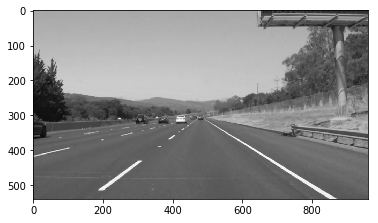

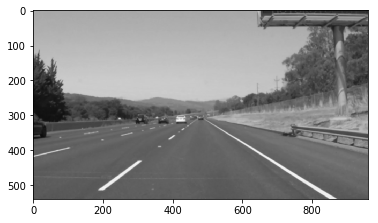

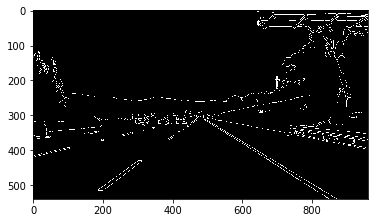

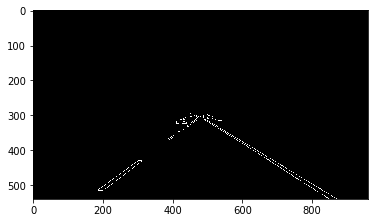

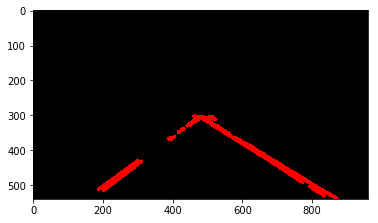

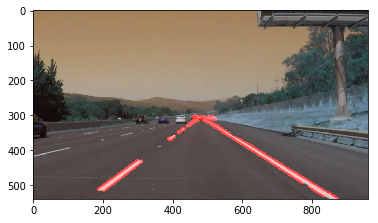

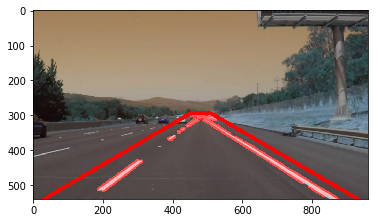

In [10]:

# Video writer parameters
cap = cv2.VideoCapture('test_videos/solidWhiteRight.mp4')
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
framerate = cap.get(cv2.CAP_PROP_FPS)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('copi.mp4',fourcc, framerate, 
                      (int(width), int(height)))


print(width)
print(height)
print(framerate)

count = 0
while cap.isOpened():
    ret,frame = cap.read()
    # print(type(frame))
    # print(frame)
    if ret:
        # cv2.imshow('window-name',frame)
        processFrame(frame)
        # cv2.imwrite("frame%d.jpg" % count, frame)
        count = count + 1
        break
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    else:
        break


cap.release()
out.release()
cv2.destroyAllWindows()  # destroy all the opened windows